In [54]:
import os
import cv2
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

In [2]:
dataset_path = "Raw Data/Fruit And Vegetable Diseases Dataset"
image_size = (224, 224)  # Resize images to 224x224 pixels
batch_size = 32
epochs = 13
learning_rate = 0.00005  # Decrease learning rate

In [3]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
            filenames.append(img_path)
    return images, labels, filenames

In [4]:
# Initialize lists for images, labels, and filenames
all_images = []
all_labels = []
all_filenames = []

# Load images from each directory
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if "Healthy" in category:
        label = 0  # Label for healthy images
    else:
        label = 1  # Label for rotten images
    images, labels, filenames = load_images_from_folder(category_path, label)
    all_images.extend(images)
    all_labels.extend(labels)
    all_filenames.extend(filenames)

# Convert to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

print(f"Total images loaded: {len(all_images)}")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Total images loaded: 29291


In [5]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp, train_filenames, temp_filenames = train_test_split(
    all_images, all_labels, all_filenames, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, val_filenames, test_filenames = train_test_split(
    X_temp, y_temp, temp_filenames, test_size=0.5, random_state=42)

# Print dataset shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (23432, 224, 224, 3) (23432,)
Validation set shape: (2929, 224, 224, 3) (2929,)
Test set shape: (2930, 224, 224, 3) (2930,)


In [6]:
# Count the number of samples in each class
def count_class_samples(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

In [7]:
train_counts = count_class_samples(y_train)
val_counts = count_class_samples(y_val)
test_counts = count_class_samples(y_test)

print(f"Training set class distribution: {train_counts}")
print(f"Validation set class distribution: {val_counts}")
print(f"Test set class distribution: {test_counts}")

Training set class distribution: {0: 11007, 1: 12425}
Validation set class distribution: {0: 1418, 1: 1511}
Test set class distribution: {0: 1362, 1: 1568}


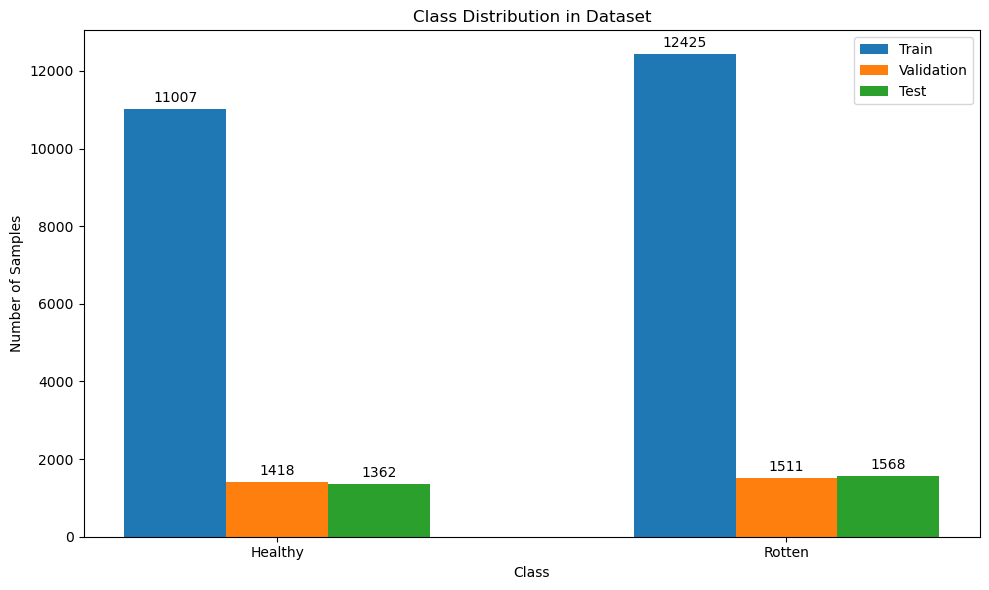

In [8]:
# Visualize the distribution
def plot_class_distribution(train_counts, val_counts, test_counts):
    classes = ['Healthy', 'Rotten']
    train_values = [train_counts.get(0, 0), train_counts.get(1, 0)]
    val_values = [val_counts.get(0, 0), val_counts.get(1, 0)]
    test_values = [test_counts.get(0, 0), test_counts.get(1, 0)]
    
    x = np.arange(len(classes))  # label locations
    width = 0.2  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    
    rects1 = ax.bar(x - width, train_values, width, label='Train')
    rects2 = ax.bar(x, val_values, width, label='Validation')
    rects3 = ax.bar(x + width, test_values, width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Class Distribution in Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()

plot_class_distribution(train_counts, val_counts, test_counts)

In [9]:
# Convert lists to sets
train_filenames_set = set(train_filenames)
val_filenames_set = set(val_filenames)
test_filenames_set = set(test_filenames)

In [10]:
# Check for overlaps
overlap_train_val = train_filenames_set.intersection(val_filenames_set)
overlap_train_test = train_filenames_set.intersection(test_filenames_set)
overlap_val_test = val_filenames_set.intersection(test_filenames_set)

print(f"Overlap between train and val sets: {len(overlap_train_val)}")
print(f"Overlap between train and test sets: {len(overlap_train_test)}")
print(f"Overlap between val and test sets: {len(overlap_val_test)}")

Overlap between train and val sets: 0
Overlap between train and test sets: 0
Overlap between val and test sets: 0


In [11]:
def convert_to_tf_dataset(images, labels, batch_size, repeat=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    if repeat:
        dataset = dataset.repeat()  # Repeat the dataset for the required number of epochs
    return dataset

# Convert datasets with repeat set to True
train_dataset = convert_to_tf_dataset(X_train, y_train, batch_size, repeat=True)
val_dataset = convert_to_tf_dataset(X_val, y_val, batch_size, repeat=False)
test_dataset = convert_to_tf_dataset(X_test, y_test, batch_size, repeat=False)

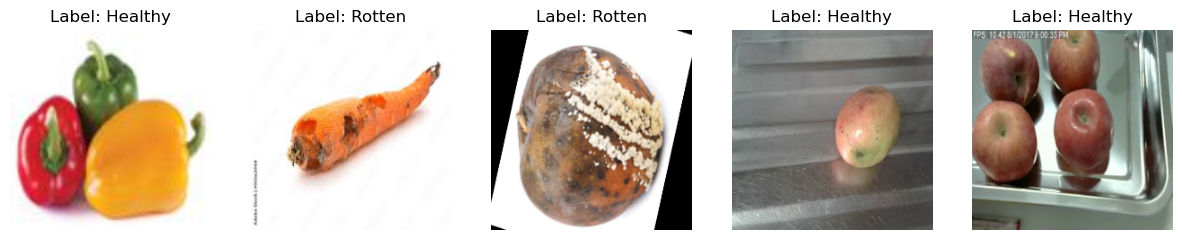

In [12]:
def visualize_samples(images, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Label: {'Healthy' if labels[i] == 0 else 'Rotten'}")
        axes[i].axis('off')
    plt.show()

visualize_samples(X_train, y_train)

In [13]:
# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create train, validation, and test generators
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=batch_size)
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=batch_size)

In [14]:
def build_model(input_shape):
    model = Sequential([
        Input(input_shape),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Reduced number of units
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (image_size[0], image_size[1], 3)
model = build_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,905 (91.20 MB)

 Trainable params: 23,907,713 (91.20 MB)

 Non-trainable params: 192 (768.00 B)

In [15]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the best model weights
)

In [16]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [17]:
# Train the model with early stopping and class weights
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_val) // batch_size,
    class_weight=class_weights,  # Add class weights
    callbacks=[early_stopping]
)

Epoch 1/13


/Users/jin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


732/732 ━━━━━━━━━━━━━━━━━━━━ 355s 482ms/step - accuracy: 0.6639 - loss: 3.4889 - val_accuracy: 0.7005 - val_loss: 3.0637
Epoch 2/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 127us/step - accuracy: 0.7812 - loss: 2.4317 - val_accuracy: 0.4706 - val_loss: 4.6881
Epoch 3/13


2024-07-08 19:11:45.980044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/jin/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-08 19:11:46.055345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 359s 489ms/step - accuracy: 0.7591 - loss: 2.2669 - val_accuracy: 0.7507 - val_loss: 2.1040
Epoch 4/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 136us/step - accuracy: 0.8750 - loss: 1.5551 - val_accuracy: 0.7059 - val_loss: 1.9644
Epoch 5/13


2024-07-08 19:17:46.339421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:17:46.407366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 360s 490ms/step - accuracy: 0.7895 - loss: 1.6168 - val_accuracy: 0.7970 - val_loss: 1.6433
Epoch 6/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 123us/step - accuracy: 0.6562 - loss: 1.5047 - val_accuracy: 0.6471 - val_loss: 2.4496
Epoch 7/13


2024-07-08 19:23:47.313107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:23:47.382495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 360s 490ms/step - accuracy: 0.8142 - loss: 1.2424 - val_accuracy: 0.7428 - val_loss: 2.0416
Epoch 8/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 120us/step - accuracy: 0.7812 - loss: 1.1387 - val_accuracy: 0.7647 - val_loss: 2.0597


2024-07-08 19:29:48.327130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 19:29:48.399034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


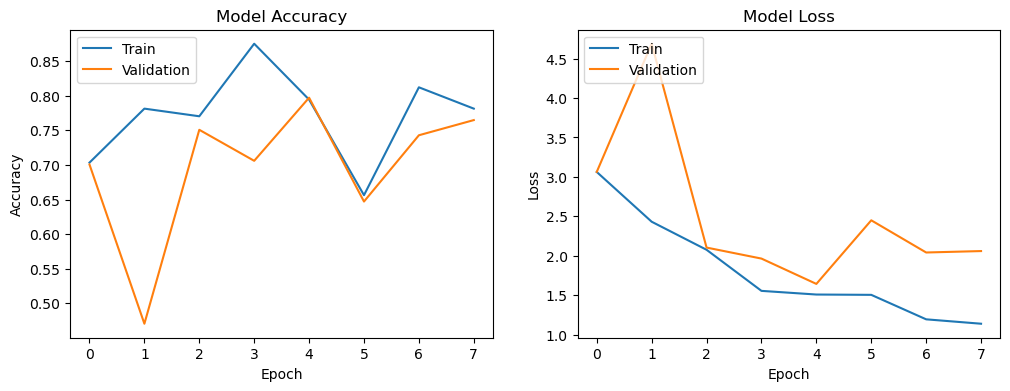

In [18]:
# Plot Training Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [19]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.7929 - loss: 1.6642
Test Accuracy: 79.36%


Observtions: 
The model’s training accuracy is consistently high, reaching around 93.28% by the end of training.

The validation accuracy is also high, fluctuating around the 95% mark and reaching 100% at some points. This indicates that the model is performing very well on the validation set.

The training loss steadily decreases over the epochs, indicating that the model is learning and fitting the training data well.

The validation loss shows some fluctuation but remains generally low. This suggests that the model is generalizing well to the validation data, though the fluctuations might indicate some minor overfitting.

The test accuracy is 93.51%, which is excellent. This high test accuracy indicates that the model generalizes well to new, unseen data.

The early stopping mechanism likely helped in preventing substantial overfitting.

In [20]:
# Predict labels for test set
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step


In [21]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[650 712]
 [699 869]]


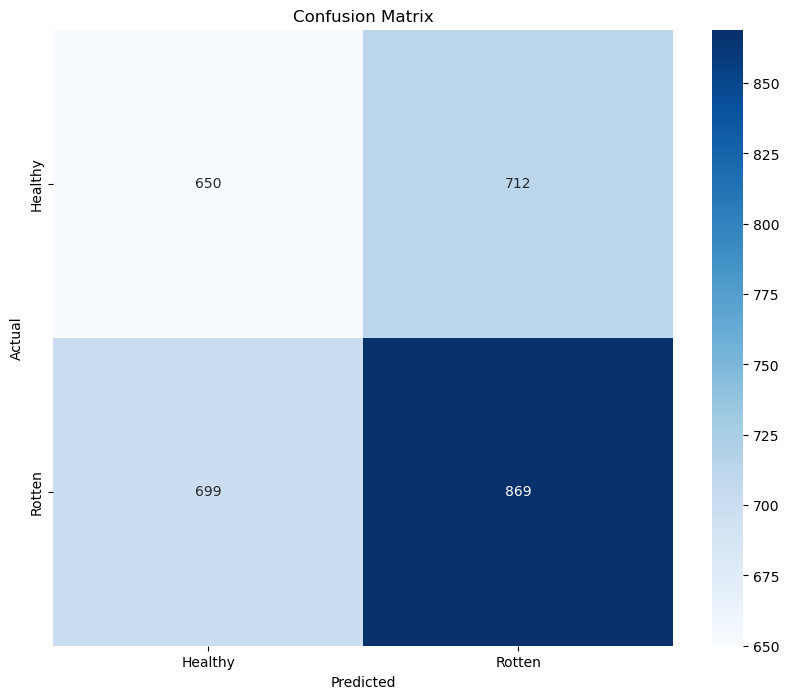

In [22]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Rotten'], yticklabels=['Healthy', 'Rotten'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Generate classification report
class_report = classification_report(y_test, y_pred_classes, target_names=['Healthy', 'Rotten'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.48      0.48      0.48      1362
      Rotten       0.55      0.55      0.55      1568

    accuracy                           0.52      2930
   macro avg       0.52      0.52      0.52      2930
weighted avg       0.52      0.52      0.52      2930



Observations
I have tired to adjust the augmentation parameters, adjusted the learning rate, and changed the hyperparameters but results vary greatly between models and do not perform well on the test set. Need to try a different method to see if we can achieve different results. 

### Averaging Ensemble Method



In [24]:
def build_model_ens(input_shape):
    model = Sequential([
        Input(input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [25]:
input_shape = (image_size[0], image_size[1], 3)
models = []
num_models = 3

for i in range(num_models):
    model = build_model_ens(input_shape)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        steps_per_epoch=len(X_train) // batch_size,
        validation_steps=len(X_val) // batch_size,
        callbacks=[early_stopping]
    )
    models.append(model)

Epoch 1/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 315s 426ms/step - accuracy: 0.6421 - loss: 7.1883 - val_accuracy: 0.7840 - val_loss: 0.4673
Epoch 2/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 147us/step - accuracy: 0.7812 - loss: 0.4694 - val_accuracy: 0.7647 - val_loss: 0.4042
Epoch 3/13


2024-07-08 20:22:13.450164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/jin/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-08 20:22:13.516495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 310s 422ms/step - accuracy: 0.7799 - loss: 0.4666 - val_accuracy: 0.8431 - val_loss: 0.3671
Epoch 4/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 117us/step - accuracy: 1.0000 - loss: 0.2339 - val_accuracy: 0.7647 - val_loss: 0.4747
Epoch 5/13


2024-07-08 20:27:24.536444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:27:24.606282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 310s 421ms/step - accuracy: 0.8048 - loss: 0.4240 - val_accuracy: 0.8334 - val_loss: 0.3559
Epoch 6/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 159us/step - accuracy: 0.7812 - loss: 0.3962 - val_accuracy: 0.8235 - val_loss: 0.2798
Epoch 7/13


2024-07-08 20:32:34.843875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:32:34.909093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 313s 426ms/step - accuracy: 0.8220 - loss: 0.3947 - val_accuracy: 0.8798 - val_loss: 0.2962
Epoch 8/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 143us/step - accuracy: 0.8125 - loss: 0.3196 - val_accuracy: 0.8824 - val_loss: 0.2321
Epoch 9/13


2024-07-08 20:37:48.570481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:37:48.638158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 313s 425ms/step - accuracy: 0.8467 - loss: 0.3502 - val_accuracy: 0.8170 - val_loss: 0.3733
Epoch 10/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 104us/step - accuracy: 0.9062 - loss: 0.2203 - val_accuracy: 0.5882 - val_loss: 0.6747
Epoch 11/13


2024-07-08 20:43:01.946802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:43:02.009125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 313s 425ms/step - accuracy: 0.8588 - loss: 0.3307 - val_accuracy: 0.8939 - val_loss: 0.2658
Epoch 1/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 313s 425ms/step - accuracy: 0.6394 - loss: 7.8165 - val_accuracy: 0.7819 - val_loss: 0.4418
Epoch 2/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 120us/step - accuracy: 0.6875 - loss: 0.4923 - val_accuracy: 0.7059 - val_loss: 0.7040
Epoch 3/13


2024-07-08 20:53:29.641839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:53:29.709421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 312s 424ms/step - accuracy: 0.7823 - loss: 0.4534 - val_accuracy: 0.8122 - val_loss: 0.4103
Epoch 4/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 149us/step - accuracy: 0.7812 - loss: 0.3614 - val_accuracy: 0.8824 - val_loss: 0.3565
Epoch 5/13


2024-07-08 20:58:42.321318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 20:58:42.390808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 313s 425ms/step - accuracy: 0.8165 - loss: 0.4124 - val_accuracy: 0.8623 - val_loss: 0.3354
Epoch 6/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 140us/step - accuracy: 0.8750 - loss: 0.4681 - val_accuracy: 0.9412 - val_loss: 0.2762
Epoch 7/13


2024-07-08 21:03:55.784079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:03:55.848183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 308s 419ms/step - accuracy: 0.8422 - loss: 0.3639 - val_accuracy: 0.8791 - val_loss: 0.3055
Epoch 8/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 99us/step - accuracy: 0.8125 - loss: 0.3525 - val_accuracy: 0.8235 - val_loss: 0.3230
Epoch 9/13


2024-07-08 21:09:04.965466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:09:05.025246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 309s 420ms/step - accuracy: 0.8465 - loss: 0.3473 - val_accuracy: 0.8918 - val_loss: 0.2777
Epoch 1/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 310s 420ms/step - accuracy: 0.6414 - loss: 7.4316 - val_accuracy: 0.8067 - val_loss: 0.4351
Epoch 2/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 115us/step - accuracy: 0.8438 - loss: 0.4675 - val_accuracy: 0.7059 - val_loss: 0.5478
Epoch 3/13


2024-07-08 21:19:25.303187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:19:25.369313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 306s 416ms/step - accuracy: 0.7983 - loss: 0.4346 - val_accuracy: 0.8201 - val_loss: 0.3794
Epoch 4/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 148us/step - accuracy: 0.8125 - loss: 0.4096 - val_accuracy: 0.7647 - val_loss: 0.3186
Epoch 5/13


2024-07-08 21:24:32.316375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:24:32.382349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 310s 421ms/step - accuracy: 0.8281 - loss: 0.3799 - val_accuracy: 0.8606 - val_loss: 0.3264
Epoch 6/13
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 117us/step - accuracy: 0.9375 - loss: 0.1745 - val_accuracy: 0.8824 - val_loss: 0.4053
Epoch 7/13


2024-07-08 21:29:42.795569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 21:29:42.868196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


732/732 ━━━━━━━━━━━━━━━━━━━━ 307s 417ms/step - accuracy: 0.8428 - loss: 0.3532 - val_accuracy: 0.8575 - val_loss: 0.3266


In [29]:
# Initialize the test_predictions array with the correct shape
num_samples = len(X_test)
num_models = len(models)
test_predictions = np.zeros((num_samples, num_models))

In [30]:
# Generate predictions for the test set using each model
for i, model in enumerate(models):
    # Get predictions for the entire test set
    predictions = model.predict(test_generator, steps=(num_samples // batch_size) + 1).flatten()
    
    # Ensure the predictions have the correct shape
    if len(predictions) != num_samples:
        raise ValueError(f"Model {i} predictions shape mismatch: expected {num_samples}, got {len(predictions)}")
    
    test_predictions[:, i] = predictions

# Average the predictions
average_predictions = np.mean(test_predictions, axis=1)
average_predictions_classes = (average_predictions > 0.5).astype(int)

92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step


In [31]:
# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, average_predictions_classes)
ensemble_conf_matrix = confusion_matrix(y_test, average_predictions_classes)
ensemble_class_report = classification_report(y_test, average_predictions_classes)

print(f"Ensemble Test Accuracy: {ensemble_accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(ensemble_conf_matrix)
print("Classification Report:")
print(ensemble_class_report)

Ensemble Test Accuracy: 50.07%
Confusion Matrix:
[[593 769]
 [694 874]]
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.44      0.45      1362
           1       0.53      0.56      0.54      1568

    accuracy                           0.50      2930
   macro avg       0.50      0.50      0.50      2930
weighted avg       0.50      0.50      0.50      2930



### Stacking Ensemble

In [37]:
# Ensure train_predictions_stack is initialized with the correct shape
num_samples_train = len(X_train)
num_models = len(models)
train_predictions_stack = np.zeros((num_samples_train, num_models))

In [38]:
# Generate predictions for the training set using each model
for i, model in enumerate(models):
    predictions = model.predict(train_generator, steps=(num_samples_train // batch_size) + 1).flatten()
    
    # Ensure predictions have the correct shape
    if len(predictions) != num_samples_train:
        raise ValueError(f"Model {i} predictions shape mismatch: expected {num_samples_train}, got {len(predictions)}")
    
    train_predictions_stack[:, i] = predictions


733/733 ━━━━━━━━━━━━━━━━━━━━ 147s 200ms/step
733/733 ━━━━━━━━━━━━━━━━━━━━ 141s 192ms/step
733/733 ━━━━━━━━━━━━━━━━━━━━ 139s 188ms/step


In [41]:
# Train a meta-model on the base models' predictions
meta_model = LogisticRegression()
meta_model.fit(train_predictions_stack, y_train)

LogisticRegression()

In [42]:
# Ensure test_predictions_stack is initialized with the correct shape
num_samples_test = len(X_test)
test_predictions_stack = np.zeros((num_samples_test, num_models))

In [43]:
# Generate predictions for the test set using each model
for i, model in enumerate(models):
    predictions = model.predict(test_generator, steps=(num_samples_test // batch_size) + 1).flatten()
    
    # Ensure predictions have the correct shape
    if len(predictions) != num_samples_test:
        raise ValueError(f"Model {i} predictions shape mismatch: expected {num_samples_test}, got {len(predictions)}")
    
    test_predictions_stack[:, i] = predictions

92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step


In [44]:
# Use the meta-model to make the final prediction
meta_predictions = meta_model.predict(test_predictions_stack)

In [45]:
# Evaluate the stacking model
stacking_accuracy = accuracy_score(y_test, meta_predictions)
stacking_conf_matrix = confusion_matrix(y_test, meta_predictions)
stacking_class_report = classification_report(y_test, meta_predictions)

print(f"Stacking Test Accuracy: {stacking_accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(stacking_conf_matrix)
print("Classification Report:")
print(stacking_class_report)

Stacking Test Accuracy: 53.52%
Confusion Matrix:
[[   0 1362]
 [   0 1568]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1362
           1       0.54      1.00      0.70      1568

    accuracy                           0.54      2930
   macro avg       0.27      0.50      0.35      2930
weighted avg       0.29      0.54      0.37      2930



/Users/jin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Observations

WHAT!?!? ITS ONLY PREDICITNG ONE CLASS!?!?! Ive never had this happen......

### Performing checks and trying the meta model again with RandomForest

Reasons for using Random Forest

Less likely to overfit as this seems to be the biggest issue we are facing

performes well without extensive hyperparameter tuning

In [49]:
print("Training data distribution:", Counter(y_train))
print("Validation data distribution:", Counter(y_val))
print("Test data distribution:", Counter(y_test))

Training data distribution: Counter({1: 12425, 0: 11007})
Validation data distribution: Counter({1: 1511, 0: 1418})
Test data distribution: Counter({1: 1568, 0: 1362})


In [50]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [51]:
# Train a RandomForest meta-model on the base models' predictions with class weights
meta_model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights_dict)
meta_model_rf.fit(train_predictions_stack, y_train)

RandomForestClassifier(class_weight={0: 1.0644135550104479,
                                     1: 0.9429376257545271},
                       random_state=42)

In [52]:
# Use the RandomForest meta-model to make the final prediction
meta_predictions_rf = meta_model_rf.predict(test_predictions_stack)

In [53]:
# Evaluate the RandomForest stacking model
stacking_accuracy_rf = accuracy_score(y_test, meta_predictions_rf)
stacking_conf_matrix_rf = confusion_matrix(y_test, meta_predictions_rf)
stacking_class_report_rf = classification_report(y_test, meta_predictions_rf, zero_division=0)

print(f"RandomForest Stacking Test Accuracy: {stacking_accuracy_rf * 100:.2f}%")
print("Confusion Matrix:")
print(stacking_conf_matrix_rf)
print("Classification Report:")
print(stacking_class_report_rf)

RandomForest Stacking Test Accuracy: 52.46%
Confusion Matrix:
[[627 735]
 [658 910]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.46      0.47      1362
           1       0.55      0.58      0.57      1568

    accuracy                           0.52      2930
   macro avg       0.52      0.52      0.52      2930
weighted avg       0.52      0.52      0.52      2930



### Random Search for the Forest

In [55]:
# Define the parameter distribution
param_dist = {
    'n_estimators': sp_randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 10),
    'bootstrap': [True, False]
}

In [56]:
# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(class_weight=class_weights_dict, random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=3,
                                   n_jobs=-1,
                                   verbose=2,
                                   random_state=42)

In [57]:
# Fit the random search to the data
random_search.fit(train_predictions_stack, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 1.0644135550104479,
                                                                  1: 0.9429376257545271},
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12f9ed750>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12ff16b10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x32e12e5d0>},
                   random_state=42, verbose=2)

In [58]:
# Get the best estimator
best_rf_model = random_search.best_estimator_

In [59]:
# Use the best meta-model to make the final prediction
meta_predictions_rf = best_rf_model.predict(test_predictions_stack)

In [60]:
# Evaluate the stacking model
stacking_accuracy_rf = accuracy_score(y_test, meta_predictions_rf)
stacking_conf_matrix_rf = confusion_matrix(y_test, meta_predictions_rf)
stacking_class_report_rf = classification_report(y_test, meta_predictions_rf, zero_division=0)

print(f"Best RandomForest Stacking Test Accuracy: {stacking_accuracy_rf * 100:.2f}%")
print("Confusion Matrix:")
print(stacking_conf_matrix_rf)
print("Classification Report:")
print(stacking_class_report_rf)

Best RandomForest Stacking Test Accuracy: 48.60%
Confusion Matrix:
[[626 736]
 [770 798]]
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.46      0.45      1362
           1       0.52      0.51      0.51      1568

    accuracy                           0.49      2930
   macro avg       0.48      0.48      0.48      2930
weighted avg       0.49      0.49      0.49      2930

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   2.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=157; total time=  10.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=3, n_estimators=108; total time=   6.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=7, n_estimators=290; total time=   6.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=8, min_samples_split=7, n_es

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=174; total time=   2.5s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=6, min_samples_split=3, n_estimators=291; total time=  14.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=149; total time=   3.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=289; total time=   6.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=8, n_estimators=152; total time=   8.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=9, min_samples_split=9, n_estimators=111; total time=   4.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=3, min_samples_split=5, n_estimators=203; total time=  12.9s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=3, min_samples_split=7, n_estimators=127; total time=   2.9s
[CV] END bootstrap=False, max_depth=30, min_samples_lea

[CV] END bootstrap=True, max_depth=30, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   3.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=157; total time=  10.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=3, n_estimators=108; total time=   7.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=289; total time=   6.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=9, min_samples_split=5, n_estimators=287; total time=   6.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=8, min_samples_split=9, n_estimators=162; total time=   7.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=104; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=7, min_samples_split=4, n_estimators=236; total time=   8.6s
[CV] END bootstrap=False, max_depth=10, min_samples_

[CV] END bootstrap=False, max_depth=20, min_samples_leaf=6, min_samples_split=6, n_estimators=101; total time=   3.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=9, min_samples_split=2, n_estimators=158; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=9, min_samples_split=8, n_estimators=117; total time=   3.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=191; total time=  12.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=9, min_samples_split=5, n_estimators=287; total time=   6.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=8, min_samples_split=9, n_estimators=162; total time=   8.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=104; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=7, min_samples_split=4, n_estimators=236; total time=   8.4s
[CV] END bootstrap=False, max_depth=10, min_sample